# Load Dataset in Dataframe 

full_data : each trial in one row with shape (name_trial (index), 7168 signals)

label : pandas series with 1 if like and 0 if dislike

In [1]:
from pathlib import Path
import pandas as pd
from sklearn.metrics import auc
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from utils import filter_data, visualize_signal
%reload_ext autoreload
directory = Path("..") / "Data" / "sensor_data"
directory2 = Path("..") / "Data" / "labels"


nc = 14 # number of channels
nt = 512 # number of signals


names = list(map(lambda x: x.split('.')[0], filter(lambda x: x.split('.')[1]=='txt', os.listdir(directory)))) # filters out the participants names from the files
full_data = pd.DataFrame(index=names, columns=np.arange(nc*nt), dtype='float64') # initialize empty dataframe to fill in, index are names of participants
labels = pd.Series(index=names) 

# loops over directort of sensor data and appends the data to the dataframe
# the corresponding label is appended to the pandas series
for n, filename in enumerate(os.listdir(directory)):
    if filename.endswith(".txt"):
        name = filename.split('.')[0]
        
        content = np.loadtxt(os.path.join(directory, filename)).T
        
        full_data.loc[name, :] = content.reshape(-1)
        
        content = open(os.path.join(directory2, filename), "r").read()
        labels[name] = 1 if content == 'Like' else 0
    


display(full_data.head())
display(labels.head())

C:\Users\mleon\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


0            1            2            3            4     \
Abhishek_1   3689.743590  3699.487179  3708.717949  3719.487179  3727.179487   
Abhishek_10  4181.538462  4176.410256  4183.076923  4184.102564  4180.000000   
Abhishek_11  4243.589744  4249.230769  4248.205128  4248.717949  4249.230769   
Abhishek_12  4278.461538  4265.128205  4266.666667  4277.948718  4275.897436   
Abhishek_13  4169.230769  4172.820513  4173.333333  4161.538462  4164.102564   

                    5            6            7            8            9     \
Abhishek_1   3727.692308  3723.589744  3727.692308  3746.153846  3766.153846   
Abhishek_10  4179.487179  4175.384615  4169.230769  4162.564103  4162.564103   
Abhishek_11  4250.769231  4262.564103  4266.666667  4257.948718  4250.256410   
Abhishek_12  4267.179487  4263.589744  4267.179487  4267.692308  4259.487179   
Abhishek_13  4173.333333  4172.820513  4175.897436  4187.692308  4192.307692   

             ...         7158         7159         7160         7161  \
Abhishek_1   ...  4247.692308  4245.128205  4247.179487  4252.307692   
Abhishek_10  ...  4237.948718  4226.666667  4217.435897  4223.589744   
Abhishek_11  ...  4202.564103  4196.410256  4191.794872  4194.871795   
Abhishek_12  ...  4194.871795  4197.948718  4194.871795  4192.307692   
Abhishek_13  ...  4080.000000  4086.153846  4087.179487  4086.153846   

                    7162         7163         7164         7165         7166  \
Abhishek_1   4251.794872  4247.179487  4246.153846  4247.692308  4253.333333   
Abhishek_10  4225.128205  4221.538462  4227.692308  4234.871795  4241.538462   
Abhishek_11  4198.461538  4204.102564  4208.717949  4216.923077  4215.897436   
Abhishek_12  4200.000000  4197.435897  4184.102564  4174.871795  4173.333333   
Abhishek_13  4082.051282  4082.051282  4086.666667  4097.435897  4105.641026   

                    7167  
Abhishek_1   4255.384615  
Abhishek_10  4252.307692  
Abhishek_11  4209.230769  
Abhishek_12  4170.769231  
Abhishek_13  4097.435897  

[5 rows x 7168 columns]

Abhishek_1     1.0
Abhishek_10    0.0
Abhishek_11    0.0
Abhishek_12    1.0
Abhishek_13    1.0
dtype: float64

# Filter Data and Visualize Signal (Raw vs. Filtered)

Setting up band-pass filter from 0.5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 845 samples (6.602 sec)



C:\Users\mleon\EEG_Product_Choice\Training_Testing\utils.py:41: RuntimeWarning: filter_length (845) is longer than the signal (512), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_x = mne.filter.filter_data(data.values.reshape(1045, nc, nt), sfreq= sfreq, h_freq = hfreq, l_freq = lfreq)


Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.


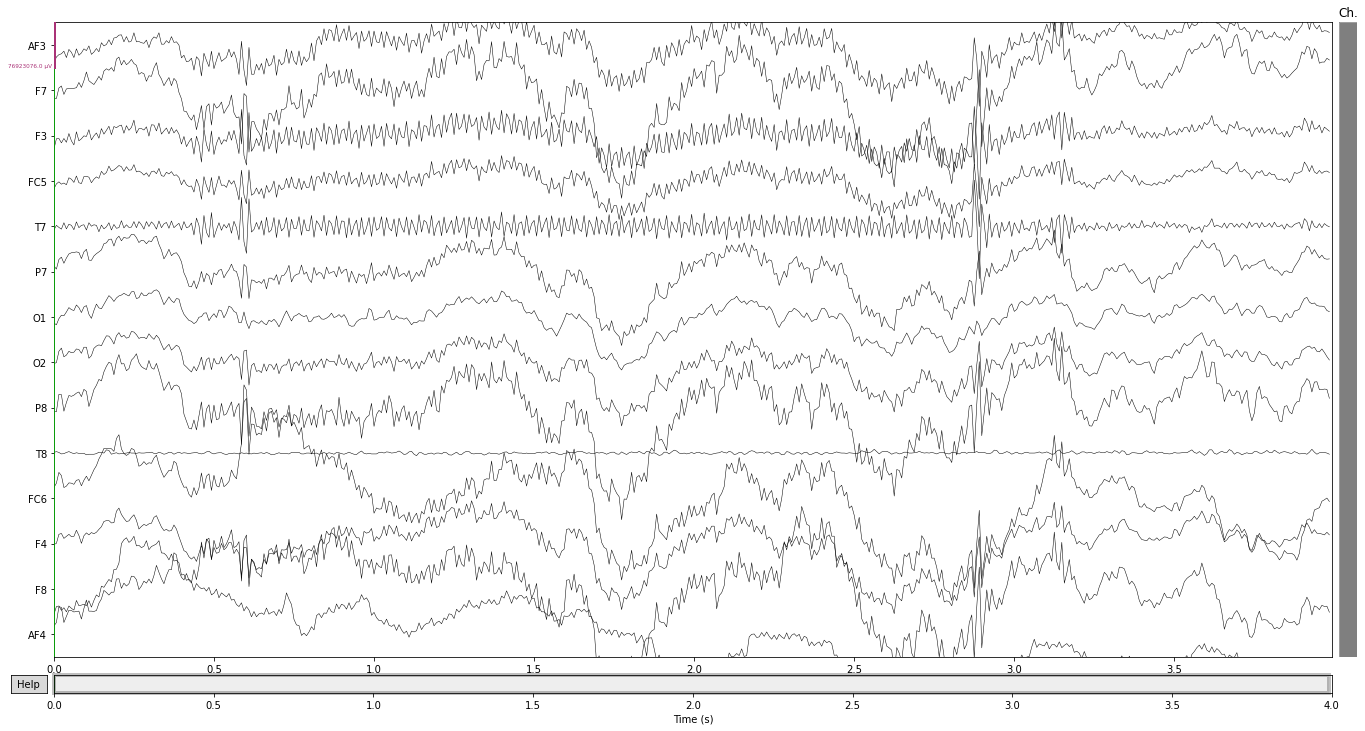

Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.


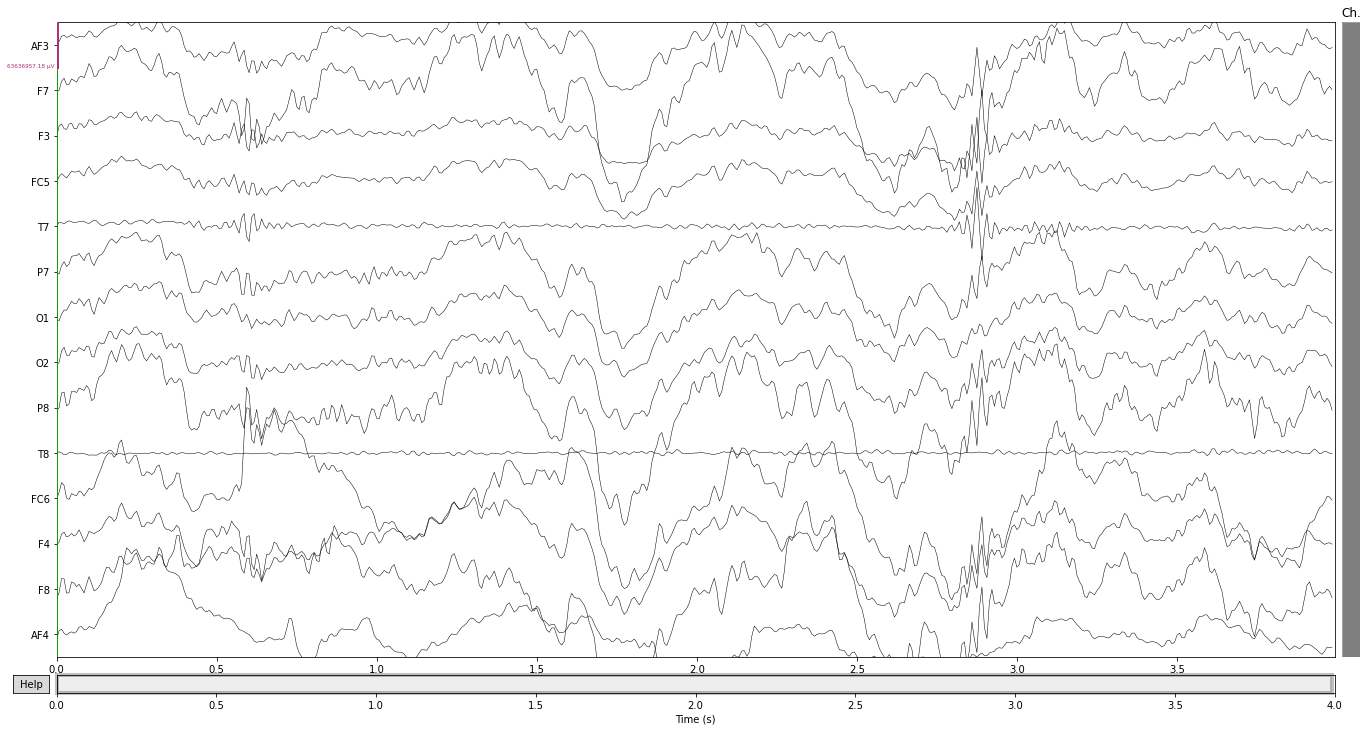

In [2]:
filtered_x_df = filter_data(full_data, sfreq = 128, lfreq=0.5, hfreq=35, nc=14, nt=512, names = names)

visualize_signal(full_data, 128, 789)

visualize_signal(filtered_x_df, 128, 789)

# Extract Band Energies and evaluate Ensemble

In [3]:
from mne_features.univariate import compute_energy_freq_bands
from mne_features.feature_extraction import extract_features

tmp = full_data.values.reshape(1045, 14, 512)

energy = extract_features(sfreq=128, X=tmp, selected_funcs = {"energy_freq_bands"}, funcs_params=
                          {"energy_freq_bands__freq_bands":np.array([0.5,4.,8.,13.,35.])}, return_as_df=True)

energy

energy_freq_bands                                              \
             ch0_band0      ch0_band1      ch0_band2     ch0_band3   
0         3.506167e+04   26873.870525   14340.107551  5.460711e+04   
1         7.525544e+03    6881.682814   10984.386842  3.380049e+04   
2         2.246737e+04    9730.909900    9189.831275  3.781908e+04   
3         2.624305e+04   12420.593281    8227.995078  3.803143e+04   
4         1.028761e+04    8340.837438   10982.006233  3.274136e+04   
...                ...            ...            ...           ...   
1040      4.880933e+03    5819.342928    5494.900651  2.830336e+04   
1041      4.499033e+03    4940.667559    6774.697137  2.502534e+04   
1042      3.765240e+03    4602.276911    7987.411111  2.430889e+04   
1043      7.340966e+04  116907.023653  244368.424896  4.572938e+05   
1044      1.123969e+06  518737.253396  631048.373419  1.046708e+06   

                                                                             \
         ch1_band0      ch1_band1     ch1_band2     ch1_band3     ch2_band0   
0     1.094100e+05   66762.457768  3.276203e+04  1.227459e+05  4.836012e+04   
1     1.385576e+04   15218.630732  2.337088e+04  6.119553e+04  6.308750e+03   
2     5.484164e+04   18299.749128  1.679718e+04  6.002561e+04  1.475268e+04   
3     3.982756e+04   19689.169814  1.495948e+04  7.530934e+04  2.192707e+04   
4     2.834054e+04   17573.296809  1.828502e+04  6.132257e+04  9.199093e+03   
...            ...            ...           ...           ...           ...   
1040  1.828671e+04    6143.779942  7.860041e+03  1.045883e+05  7.972123e+03   
1041  1.680501e+04    8376.428493  1.248773e+04  7.943982e+04  1.459370e+03   
1042  7.570491e+03    6952.151251  1.484075e+04  8.501362e+04  4.095782e+03   
1043  1.283934e+05  222438.975723  4.391318e+05  8.922653e+05  5.430704e+04   
1044  2.217214e+06  907605.435179  1.139955e+06  2.354620e+06  1.034115e+06   

                     ...                                              \
          ch2_band1  ...     ch11_band2     ch11_band3    ch12_band0   
0      30650.130990  ...   11348.247653   41700.825413  1.033509e+05   
1       5569.833875  ...    8857.451944   23427.946824  1.563844e+04   
2       8251.349424  ...    8486.912214   33547.444157  3.358441e+04   
3      11263.755902  ...    5994.948284   29764.834006  4.969292e+04   
4       9400.944342  ...    9768.079201   26060.013882  2.761073e+04   
...             ...  ...            ...            ...           ...   
1040    2945.978470  ...    1992.905794   10981.177713  1.508717e+04   
1041    2933.498626  ...    1590.088209    9516.881206  1.055143e+04   
1042    3573.666328  ...    1927.606755    8051.636959  1.118332e+04   
1043   85641.901440  ...   43634.897614  104122.257232  1.191538e+05   
1044  370810.882109  ...  125218.046040  214292.098483  1.048043e+06   

                                                                             \
         ch12_band1    ch12_band2    ch12_band3    ch13_band0    ch13_band1   
0      77964.577024  3.186199e+04  1.622660e+05  18930.884495   9335.108765   
1      20329.675191  2.588168e+04  6.518242e+04  17231.742198   9223.038411   
2      24181.002306  2.929038e+04  8.962748e+04  15207.672683  13445.038076   
3      30825.564827  2.722047e+04  7.792164e+04  17531.610295  10724.871858   
4      24675.199217  2.357955e+04  7.134683e+04  30793.793229  11443.427124   
...             ...           ...           ...           ...           ...   
1040   10490.216489  1.644044e+04  6.040682e+04    722.681541    953.882934   
1041   10222.933578  1.036989e+04  5.517807e+04    704.772701    745.383350   
1042   10263.384191  1.873139e+04  5.877614e+04    551.909936    829.055385   
1043  185887.179776  3.858563e+05  7.226570e+05   8289.500839   7466.326451   
1044  693828.882589  1.122368e+06  1.920005e+06  49459.348258  26408.189415   

                                  
        ch13_band2    ch13_band3  
0      5480.786398  22370.83097

In [4]:
from sklearn.utils import compute_class_weight

classWeight = compute_class_weight('balanced', np.unique(labels), labels) 
classWeight = dict(enumerate(classWeight))

classWeight

C:\Users\mleon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0. 1.], y=Abhishek_1     1.0
Abhishek_10    0.0
Abhishek_11    0.0
Abhishek_12    1.0
Abhishek_13    1.0
              ... 
Viraj_1_5      0.0
Viraj_1_6      0.0
Viraj_1_7      0.0
Viraj_1_8      0.0
Viraj_1_9      0.0
Length: 1045, dtype: float64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.8946917808219178, 1: 1.1334056399132322}

In [8]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

scoring = {'acc': 'accuracy',
           "F1": "f1"
          }
clf1 = SVC(probability=True, class_weight = classWeight)
clf2 = LogisticRegression(max_iter=110000, class_weight = classWeight)
clf3 = RandomForestClassifier(class_weight = classWeight)

voter = VotingClassifier(estimators = [("a",clf1),("b",clf2),("c",clf3)],voting= "soft")

scores_ensemble = cross_validate(voter, energy, labels, cv=5, scoring = scoring)

In [9]:
scores_ensemble

{'fit_time': array([1.90048051, 2.84052277, 2.25931454, 2.07644486, 1.19784117]),
 'score_time': array([0.02193952, 0.0209434 , 0.03191519, 0.01894975, 0.02293754]),
 'test_acc': array([0.61722488, 0.44019139, 0.45933014, 0.54066986, 0.56937799]),
 'test_F1': array([0.49367089, 0.42926829, 0.28930818, 0.4       , 0.47674419])}

In [10]:
print(np.mean(scores_ensemble["test_acc"]), (np.mean(scores_ensemble["test_F1"])))

0.5253588516746411 0.4177983081812033


# Neural Network Architecture and Evaluation

# Simple Cross Validation

In [11]:
X = full_data.values.reshape(1045,512,14)
y = labels.copy()

In [59]:
import keras 
import tensorflow

def conv(learning_rate = 0.01, input_shape = (512,14), activation = "relu", neurons = 50):

    model = keras.models.Sequential()
        
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv1D(filters = 20, kernel_size = 1, activation = activation, input_shape = input_shape))  
    
    model.add(keras.layers.MaxPooling1D())
    
    model.add(keras.layers.Conv1D(filters = 50 , kernel_size = 3, activation = activation))
    
    model.add(keras.layers.MaxPooling1D())
            
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(neurons, activation=activation))
    
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics=["accuracy"])
           
    return model

In [46]:
from sklearn.model_selection import cross_validate
from keras.wrappers.scikit_learn import KerasClassifier


clf = KerasClassifier(conv, batch_size = 30, epochs=50, verbose=0)


scores = cross_validate(clf, X, y, cv=5, scoring = scoring, fit_params = {"class_weight": classWeight})

In [47]:
scores, np.mean(scores["test_acc"]), np.mean(scores["test_F1"])

({'fit_time': array([20.89610815,  4.30490732,  5.44377041,  5.70075631,  5.48671985]),
  'score_time': array([0.08675981, 0.12868452, 0.12834954, 0.12876987, 0.12968254]),
  'test_acc': array([0.51674641, 0.57894737, 0.50239234, 0.53588517, 0.44019139]),
  'test_F1': array([0.36477987, 0.68115942, 0.36585366, 0.43930636, 0.51851852])},
 0.5148325358851675,
 0.4739235659880596)

In [69]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, shuffle = True)

model = conv()

history = model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size = 30, epochs= 100)

Epoch 1/100
28/28 [==============================] - 0s 11ms/step - loss: 0.7104 - accuracy: 0.5275 - val_loss: 4.1280 - val_accuracy: 0.5455
Epoch 2/100
28/28 [==============================] - 0s 6ms/step - loss: 0.6710 - accuracy: 0.5921 - val_loss: 4.3813 - val_accuracy: 0.5455
Epoch 3/100
28/28 [==============================] - 0s 6ms/step - loss: 0.6435 - accuracy: 0.6280 - val_loss: 1.3955 - val_accuracy: 0.5455
Epoch 4/100
28/28 [==============================] - 0s 6ms/step - loss: 0.6353 - accuracy: 0.6447 - val_loss: 2.7111 - val_accuracy: 0.5455
Epoch 5/100
28/28 [==============================] - 0s 6ms/step - loss: 0.6184 - accuracy: 0.6459 - val_loss: 1.7507 - val_accuracy: 0.5455
Epoch 6/100
28/28 [==============================] - 0s 6ms/step - loss: 0.6099 - accuracy: 0.6699 - val_loss: 3.0098 - val_accuracy: 0.5455
Epoch 7/100
28/28 [==============================] - 0s 6ms/step - loss: 0.5956 - accuracy: 0.6794 - val_loss: 1.4861 - val_accuracy: 0.5455
Epoch 8/100


Epoch 59/100
28/28 [==============================] - 0s 6ms/step - loss: 0.1247 - accuracy: 0.9785 - val_loss: 1.3084 - val_accuracy: 0.5455
Epoch 60/100
28/28 [==============================] - 0s 6ms/step - loss: 0.1165 - accuracy: 0.9892 - val_loss: 1.3760 - val_accuracy: 0.5694
Epoch 61/100
28/28 [==============================] - 0s 6ms/step - loss: 0.2325 - accuracy: 0.9438 - val_loss: 1.4812 - val_accuracy: 0.5407
Epoch 62/100
28/28 [==============================] - 0s 6ms/step - loss: 0.5311 - accuracy: 0.8624 - val_loss: 1.0389 - val_accuracy: 0.5598
Epoch 63/100
28/28 [==============================] - 0s 8ms/step - loss: 0.2180 - accuracy: 0.9426 - val_loss: 1.2203 - val_accuracy: 0.5359
Epoch 64/100
28/28 [==============================] - 0s 6ms/step - loss: 0.1737 - accuracy: 0.9569 - val_loss: 1.2526 - val_accuracy: 0.4880
Epoch 65/100
28/28 [==============================] - 0s 6ms/step - loss: 0.1244 - accuracy: 0.9856 - val_loss: 1.2382 - val_accuracy: 0.4928
Epoch 

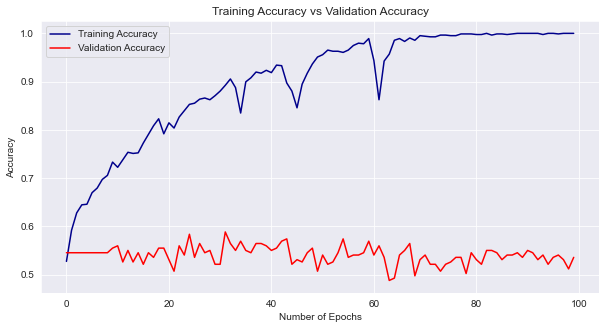

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

train_loss = history.history["loss"]
train_acc = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_acc = history.history["val_accuracy"]

plt.figure(figsize=(10,5))
sns.lineplot(x = np.arange(0,len(train_loss)), y =train_acc, legend=True, color = "darkblue")
plt.title("Training Accuracy vs Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
sns.lineplot(x = np.arange(0,len(train_loss)), y =val_acc, legend=True, color = "red")
plt.legend(["Training Accuracy", "Validation Accuracy"])

# Results with Leave one out Cross Validation

In [ ]:
import tensorflow as tf
import keras 
from sklearn.metrics import auc, accuracy_score
import scipy
from mne_features.feature_extraction import extract_features
from sklearn.cluster import KMeans




def get_results_new_cnn(data:pd.DataFrame, labels:pd.Series) -> pd.Series:
    unique_names = set(['_'.join(x.split('_')[:-1]) for x in data.index])
    results = {}

    model = keras.wrappers.scikit_learn.KerasClassifier(conv, epochs=100, batch_size=300)
    
    #m = new_rr()
    for name in unique_names:
        

        #split data N-1 for training, N for testing
        ################################################################
        train_tmp = data.filter(regex=f'^(?!.*{name}).*$', axis=0)
        X_train = train_tmp.values
        tmp = set(['_'.join(t.split('_')[:-1]) for t in train_tmp.index])
        
        
        test_tmp = data.filter(regex=f'^{name}', axis=0)
        X_test = test_tmp.values
        tmp = set(['_'.join(t.split('_')[:-1]) for t in test_tmp.index])
        ################################################################
        
        # Non-filtered data
        ##########################################################
        X_train_full = X_train.reshape(X_train.shape[0], 14, 512)
        X_test_full = X_test.reshape(X_test.shape[0], 14, 512)
        ##########################################################
        
        #filtered data
        #######################################################
        X_train_nn = X_train.reshape(X_train.shape[0], 14, 512)
        X_test_nn = X_test.reshape(X_test.shape[0], 14, 512)
        #######################################################
        
        # mne extracted features
        ########################################################################################################
#         X_train_mne = extract_features(X=X_train_full, sfreq=128, selected_funcs=selected_funcs)
                                 
        
#         X_test_mne = extract_features(X=X_test_full, sfreq=128, selected_funcs=selected_funcs)                       
        ########################################################################################################
        
        # Gramian Angular Field
        #############################################################################
        full_train = X_train_full.reshape(X_train.shape[0], 512, 14)
        full_test = X_test_full.reshape(X_test.shape[0], 512, 14)
        X_train_gramian = np.array([t.fit_transform(full_train[i]) for i in range(len(full_train))])
        X_test_gramian = np.array([t.fit_transform(full_test[i]) for i in range(len(full_test))])
                                      
        ################################################################################################                              
                                      
                                      
        
        y_train = labels.filter(regex=f'^(?!.*{name}).*$', axis=0).values
        y_test = labels.filter(regex=f'^{name}', axis=0).values
        
       
        #train + predictions
        #########################################################
        model.fit(X_train_gramian, y_train)
        
        y_pred = model.predict(X_test_gramian)
        #########################################################
        
        #test
        #########################################################
        acc_nn = accuracy_score(y_test, y_pred)
        
        results[name] = acc_nn
        print(name, acc_nn)

    results = pd.Series(results)
    return results

results = get_results_new_cnn(filtered_x_df, labels)

C:\Users\mleon\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\mleon\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\mleon\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\mleon\AppData\Local\Conti

In [55]:
results

Suraj_sir       0.333333
Viraj_1         0.738095
Vipin_1         0.523810
taufiq          0.487805
Kishore_babu    0.214286
pradeep         0.595238
Abhishek        0.571429
Ankur_sir       0.536585
Gautam_123      0.619048
mahendra        0.452381
Rockysingh      0.756098
Gautam          0.714286
Mohit           0.547619
Sandeep         0.571429
Rajesh_el       0.428571
rajkumar        0.523810
Soumendu        0.476190
Rupak           0.833333
Veerpal         0.487805
Sachin          0.619048
Vijay           0.595238
Girvar_yadav    0.595238
pawan_sahu      0.536585
Ravi_ph         0.690476
Ravi_baba       0.476190
dtype: float64

## Both Ensemble and Neural Network perform poorly on dataset, results of paper could not be replicated. I assume dataset quality is not sufficient enough. 